# Global versus local PCA

In this notebook we present how global and local PCA can be performed using `PCA` class from the `pca_impl` module.

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PCAfold.pca_impl import PCA
from sklearn.cluster import KMeans

# Set some initial parameters:
global_color = '#6a6e7a'
k1_color = '#0e7da7'
k2_color = '#ceca70'
PC_color = '#000000'
data_point = 4
save_plots = False
font_text = 20
line_width = 1
n_points = 1000

# Fonts:
csfont = {'fontname':'Charter', 'fontweight':'regular'}
hfont = {'fontname':'Charter', 'fontweight':'bold'}

# Function for plotting:
def plot_data_set(x, y, title_text=''):
    
    figure = plt.figure(figsize=(8, 5))
    figureSubplot = plt.subplot(1,1,1)
    plt.scatter(x, y, color=global_color, marker='.', linewidth=data_point-2)
    plt.xticks([]), plt.yticks([])
    plt.grid(alpha=0.2)
    plt.title(title_text, **csfont, fontsize=font_text, color=PC_color)

Create a function that will perform PCA transformation on local portions of the data set:

In [2]:
def local_pca(X, idx):

    n_k = len(np.unique(idx))

    # Initialize the outputs:
    eigenvectors = []
    eigenvalues = []
    PC_scores = []

    for k in range(0, n_k):

        # Extract local cluster:
        X_k = X[idx==k]

        # Perform PCA in a local cluster:
        pca = PCA(X_k, 'none', 2, useXTXeig=True)
        PC_scores = pca.x2eta(X_k, nocenter=False)
        eigenvectors.append(pca.Q)
        eigenvalues.append(pca.L)

    return (eigenvectors, eigenvalues, PC_scores)

***

### Generate synthetic data set on which global PCA will be performed:

This data set is composed of a single cloud:

In [3]:
mean_global = [0,1]
covariance_global = [[3.4, 1.1], [1.1, 2.1]]

x_noise, y_noise = np.random.multivariate_normal(mean_global, covariance_global, n_points).T
y_global = np.linspace(0,4,n_points)
x_global = -(y_global**2) + 7*y_global + 4
y_global = y_global + y_noise
x_global = x_global + x_noise

Dataset_global = np.hstack((x_global[:,np.newaxis], y_global[:,np.newaxis]))

Visualize the data set:

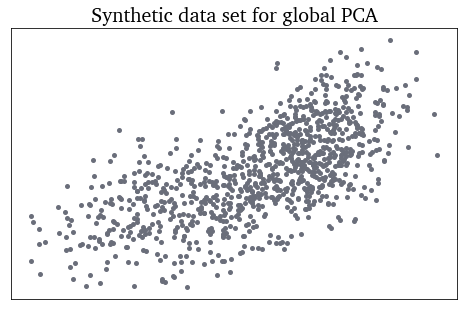

In [4]:
plot_data_set(x_global, y_global, 'Synthetic data set for global PCA')
if save_plots==True: plt.savefig('../images/tutorial-pca-data-set-for-global-pca.png', dpi = 500, bbox_inches='tight')

Perform PCA transformation of the data set:

In [5]:
# Perform PCA:
pca = PCA(Dataset_global, 'none', 2, useXTXeig=True)
PC_scores_global = pca.x2eta(Dataset_global, nocenter=False)
eigenvectors_global = pca.Q
eigenvalues_global = pca.L

# Centered data set:
Dataset_global_pp = pca.X

***

### Generate synthetic data set on which local PCA will be performed

This data set is composed of two distinct clouds:

In [6]:
mean_local_1 = [0,1]
mean_local_2 = [6,4]
covariance_local_1 = [[2, 0.5], [0.5, 0.5]]
covariance_local_2 = [[3, 0.3], [0.3, 0.5]]

x_noise_1, y_noise_1 = np.random.multivariate_normal(mean_local_1, covariance_local_1, n_points).T
x_noise_2, y_noise_2 = np.random.multivariate_normal(mean_local_2, covariance_local_2, n_points).T
x_local = np.concatenate([x_noise_1, x_noise_2])
y_local = np.concatenate([y_noise_1, y_noise_2])

Dataset_local = np.hstack((x_local[:,np.newaxis], y_local[:,np.newaxis]))

Visualize the data set:

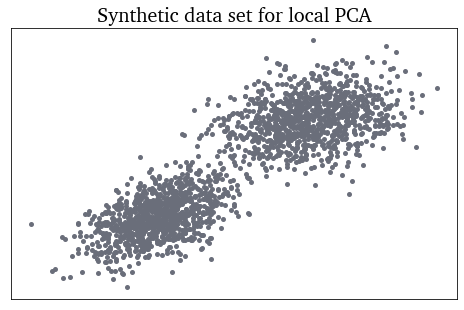

In [7]:
plot_data_set(x_local, y_local, 'Synthetic data set for local PCA')
if save_plots==True: plt.savefig('../images/tutorial-pca-data-set-for-local-pca.png', dpi = 500, bbox_inches='tight')

Cluster the data set using K-Means algorithm:

In [8]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(Dataset_local)
idx = kmeans.labels_
centroids = kmeans.cluster_centers_

Perform local PCA:

In [9]:
(eigenvectors_local, eigenvalues_local, _) = local_pca(Dataset_local, idx)

***

### Plotting PCA results

Plot the identified eigenvectors on the data set where global PCA was performed and on the data set where local PCA was performed:

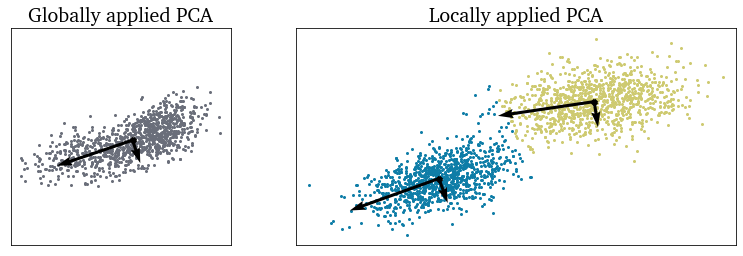

In [10]:
figure = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# First subplot - global PCA:
figureSubplot = plt.subplot(gs[0])
plt.scatter(Dataset_global_pp[:,0], Dataset_global_pp[:,1], s=data_point, color=global_color, marker='o', linewidth=line_width)

# Plot global eigenvectors:
plt.quiver(eigenvectors_global[0,0], eigenvectors_global[1,0], scale=30*(1-eigenvalues_global[0]), color=PC_color, width=0.014)
plt.quiver(eigenvectors_global[0,1], eigenvectors_global[1,1], scale=10*(1-eigenvalues_global[1]), color=PC_color, width=0.014)

plt.axis('equal')
plt.yticks([]), plt.xticks([])
plt.title('Globally applied PCA', **csfont, fontsize=font_text, color=PC_color)

# Plot global centroid:
plt.scatter(0, 0, color=PC_color, marker='x', lineWidth=data_point, s=20);

# Second subplot - local PCA:
figureSubplot = plt.subplot(gs[1])
plt.scatter(Dataset_local[idx==0,0], Dataset_local[idx==0,1], s=data_point, c=k1_color, marker='o')
plt.scatter(Dataset_local[idx==1,0], Dataset_local[idx==1,1], s=data_point, c=k2_color, marker='o')

# Plot local eigenvectors:
origin = [centroids[0][0]], [centroids[0][1]]
plt.quiver(*origin, eigenvectors_local[0][0,0], eigenvectors_local[0][1,0], scale=30*(1-eigenvalues_local[0][0]), color=PC_color, width=0.007)
plt.quiver(*origin, eigenvectors_local[0][0,1], eigenvectors_local[0][1,1], scale=20*(1-eigenvalues_local[0][1]), color=PC_color, width=0.007)

origin = [centroids[1][0]], [centroids[1][1]]
plt.quiver(*origin, eigenvectors_local[1][0,0], eigenvectors_local[1][1,0], scale=30*(1-eigenvalues_local[1][0]), color=PC_color, width=0.007)
plt.quiver(*origin, eigenvectors_local[1][0,1], eigenvectors_local[1][1,1], scale=20*(1-eigenvalues_local[1][1]), color=PC_color, width=0.007)

plt.axis('equal')
plt.yticks([]), plt.xticks([])
plt.title('Locally applied PCA', **csfont, fontsize=font_text, color=PC_color)

# Plot local centroids:
plt.scatter(centroids[:, 0], centroids[:, 1], color=PC_color, marker='x', lineWidth=data_point, s=20);

if save_plots==True: plt.savefig('../images/tutorial-pca-global-local-pca.png', dpi = 500, bbox_inches='tight')